# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [34]:
!pip install pymongo

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [35]:
!pip install pymongo[srv]

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [36]:
!pip install dnspython

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [37]:
!pip install tweepy

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [38]:
!pip install twitter

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [39]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [40]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [41]:
client = MongoClient(mongod_connect)
db = client.gp17 # use or create a database named demo
tweet_collection = db.lab11 #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [68]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [69]:
track = ['covid19'] # define the keywords, tweets contain election

locations = [-78.9326449,38.4150904,-78.8816972,38.4450731] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [70]:
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

1329497882907406336
1329497883373154311
1329497883423305728
1329497885742747649
1329497886833434626
1329497886795546626
1329497886908944384
1329497887768719369
1329497889480077315
1329497889505234953
1329497890750947328
1329497890893475842
1329497892181200897
1329497892743245828
1329497894534213640
1329497894743912448
1329497895222054914
1329497895238680576
1329497896090300417
1329497896232873984
1329497895951872006
1329497896182575111
1329497897184931840
1329497897243717634
1329497897461719040
1329497897717665797
1329497899101802499
1329497899361853443
1329497899554775041
1329497902163525632
1329497902985654279
1329497902633406465
1329497902402646019
1329497903597973504
1329497903979749376
1329497904080359425
1329497904524918784
1329497905632215042
1329497906500530179
1329497907771428866
1329497908526374913
1329497908929032195
1329497908828401665
1329497909889478657
1329497913324670976
1329497913391767553
1329497914113216517
1329497914197094401
1329497914301935621
1329497914482180097


KeyboardInterrupt: 

## Use the REST API to Collect Tweets

Authorize the REST API 

In [71]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [72]:
count = 100 #number of returned tweets, default and max is 100
geocode = "37.5247764, -775633011,150mi"  # defin the location, in Harrisonburg, VA
q = "covid19"                               #define the keywords, tweets contain election

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [73]:
search_results = rest_api.search.tweets( count=count, q=q, geocode=geocode) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

IndexError: list index out of range

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [74]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                        geocode=geocode, max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

NameError: name 'since_id_new' is not defined

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [75]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

1423
1374


Create a text index and print the Tweets containing specific keywords. 

In [76]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [77]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "vote"}}) # return tweets contain vote

Use pprint to display tweets

In [78]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: Chris Stedman
text: RT @chrisgeidner: The Republican Party does not want people who voted against them to have their votes count. This is an argument for endin…
----
name: Brad Heath
text: Giuliani says some cabal has "destroyed the right to vote" in an election in which many more Americans voted than ever before.
----
name: HARRIET TUBMAN
text: RT @dcexaminer: .@RudyGiuliani: "We use largely a Venezuelan voting machine...to count our vote. 

If we let this happen, we’re going to be…
----
name: Trump loving mama 🇺🇸
text: RT @LizRNC: EVIDENCE

"more than 15,000 votes were cast in Nevada by people who also voted in another state, 1,000 from people who don't me…
----
name: Maria C Hernandez
text: RT @LizRNC: EVIDENCE

"more than 15,000 votes were cast in Nevada by people who also voted in another state, 1,000 from people who don't me…
----
name: President elect~Jacquie~💖⭐️⭐️⭐️
text: RT @LizRNC: EVIDENCE

"more than 15,000 votes were cast in Nevada by people who also voted in an

In [79]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "vote"}}) # return tweets contain vote

Use pandas to display tweets

In [80]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,...,entities,favorited,retweeted,filter_level,lang,timestamp_ms,withheld_in_countries,display_text_range,extended_tweet,possibly_sensitive
0,5fb6b9dd40ae3269687203d9,Thu Nov 19 18:30:48 +0000 2020,1329492337798615041,1329492337798615041,RT @chrisgeidner: The Republican Party does no...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,...,"{'hashtags': [], 'urls': [], 'user_mentions': ...",False,False,low,en,1605810648761,NaN,NaN,NaN,NaN
1,5fb6b9dc40ae326968720387,Thu Nov 19 18:30:47 +0000 2020,1329492330458574851,1329492330458574851,"Giuliani says some cabal has ""destroyed the ri...","<a href=""https://mobile.twitter.com"" rel=""nofo...",False,1.329492e+18,1329491797438058500,14362404.0,...,"{'hashtags': [], 'urls': [], 'user_mentions': ...",False,False,low,en,1605810647011,NaN,NaN,NaN,NaN
2,5fb6b9df40ae32696872041d,Thu Nov 19 18:30:50 +0000 2020,1329492343456718848,1329492343456718848,"RT @dcexaminer: .@RudyGiuliani: ""We use largel...","<a href=""https://mobile.twitter.com"" rel=""nofo...",False,NaN,None,NaN,...,"{'hashtags': [], 'urls': [], 'user_mentions': ...",False,False,low,en,1605810650110,NaN,NaN,NaN,NaN
3,5fb6b9ec40ae32696872069d,Thu Nov 19 18:31:03 +0000 2020,1329492397525508096,1329492397525508096,"RT @LizRNC: EVIDENCE\n\n""more than 15,000 vote...","<a href=""http://twitter.com/download/android"" ...",False,NaN,None,NaN,...,"{'hashtags': [], 'urls': [], 'user_mentions': ...",False,False,low,en,1605810663001,NaN,NaN,NaN,NaN
4,5fb6b9e440ae326968720513,Thu Nov 19 18:30:55 +0000 2020,1329492364981919745,1329492364981919745,"RT @LizRNC: EVIDENCE\n\n""more than 15,000 vote...","<a href=""http://twitter.com/download/android"" ...",False,NaN,None,NaN,...,"{'hashtags': [], 'urls': [], 'user_mentions': ...",False,False,low,en,1605810655242,NaN,NaN,NaN,NaN
5,5fb6b9e240ae3269687204c1,Thu Nov 19 18:30:53 +0000 2020,1329492357696393217,1329492357696393217,"RT @LizRNC: EVIDENCE\n\n""more than 15,000 vote...","<a href=""https://mobile.twitter.com"" rel=""nofo...",False,NaN,None,NaN,...,"{'hashtags': [], 'urls': [], 'user_mentions': ...",False,False,low,en,1605810653505,NaN,NaN,NaN,NaN
6,5fb6b9e140ae326968720484,Thu Nov 19 18:30:52 +0000 2020,1329492352268955650,1329492352268955650,"RT @AmyMek: ""We use largely a Venezuelan votin...","<a href=""https://mobile.twitter.com"" rel=""nofo...",False,NaN,None,NaN,...,"{'hashtags': [], 'urls': [], 'user_mentions': ...",False,False,low,en,1605810652211,"[DE, FR]",NaN,NaN,NaN
7,5fb6b9da40ae326968720325,Thu Nov 19 18:30:45 +0000 2020,1329492322694823937,1329492322694823937,@kylegriffin1 ▀042\n\nMich!gan Election boards...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",True,1.329492e+18,1329492134806781954,32871086.0,...,"{'hashtags': [], 'urls': [{'url': 'https://t.c...",False,False,low,en,1605810645160,NaN,"[14, 140]",{'full_text': '@kylegriffin1 ▀042 Mich!gan El...,False
8,5fb6b9dd40ae3269687203c5,Thu Nov 19 18:30:48 +0000 2020,1329492335311417345,1329492335311417345,RT @AriBerman: Trump isn't just trying to thro...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,...,"{'hashtags': [], 'urls': [], 'user_mentions': ...",False,False,low,en,1605810648168,NaN,NaN,NaN,NaN
9,5fb6b9ec40ae3269687206ae,Thu Nov 19 18:31:03 +0000 2020,1329492398838308865,1329492398838308865,RT @RealBrysonGray: REDO THE ENTIRE ELECTION W...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,...,"{'hashtags': [], 'urls': [], 'user_mentions': ...",False,False,low,en,1605810663314,NaN,NaN,NaN,NaN


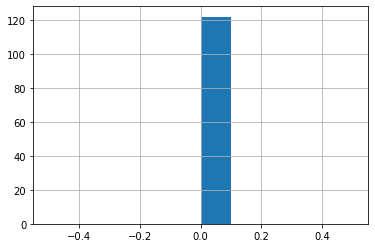

In [56]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count